# Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression

# 1) Importation et préparation des données

In [15]:
df = pd.read_csv("Openhealth_S-Grippal.csv", sep = ";")

In [16]:
# Travailler sur la variable IAS_brut uniquement
df = df[["PERIODE" , "IAS_brut"]]
df.head()

,PERIODE,IAS_brut
0,2009-07-01,"1,7"
1,2009-07-02,"3,4"
2,2009-07-03,"2,1"
3,2009-07-04,"1,3"
4,2009-07-05,"14,2"


IAS® = Indicateur Avancé de Santé (Advanced Health Indicator), développé par OpenHealth.

C’est un indicateur statistique calculé à partir des ventes de médicaments en pharmacie pour suivre en temps quasi-réel certains phénomènes de santé publique (grippe, allergies, gastro-entérite, syndromes respiratoires, etc.).

In [17]:
# Transformer la PERIODE en index
df["PERIODE"] = pd.to_datetime(df["PERIODE"])
df = df.set_index("PERIODE")
print(df)

           IAS_brut
PERIODE            
2009-07-01      1,7
2009-07-02      3,4
2009-07-03      2,1
2009-07-04      1,3
2009-07-05     14,2
...             ...
2014-04-13     77,9
2014-04-14      2,7
2014-04-15        1
2014-04-16      1,6
2014-04-17      0,4

[1752 rows x 1 columns]


In [18]:
# Inférer la fréquence de l'index
print(pd.infer_freq(df.index))
print(df.index[0])
print(df.index[-1])

D
2009-07-01 00:00:00
2014-04-17 00:00:00


Notre donnée s'étale donc de 2009 jusqu'à 2014 par un pas de temps journalier. 

In [19]:
# Vérifier s'il y a des nullités
sum(df["IAS_brut"] == 0)

0

In [20]:
pd.isnull(df["IAS_brut"]).sum()

np.int64(0)

Il n'y a pas de données manquantes dans notre donnée alors.

In [21]:
# Compter le nombre de zéros et de NaN dans la colonne 'IAS_brut'
nombre_NA = (df["IAS_brut"] == 0).sum() + df["IAS_brut"].isna().sum()
print(f"Nombre de zéros et de valeurs NaN (manquantes) dans 'IAS_brut': {nombre_NA}")

Nombre de zéros et de valeurs NaN (manquantes) dans 'IAS_brut': 0


In [22]:
# Transformer en numérique 
df["IAS_brut"] = df["IAS_brut"].str.replace(",", ".", regex=False)
df["IAS_brut"] = pd.to_numeric(df["IAS_brut"])

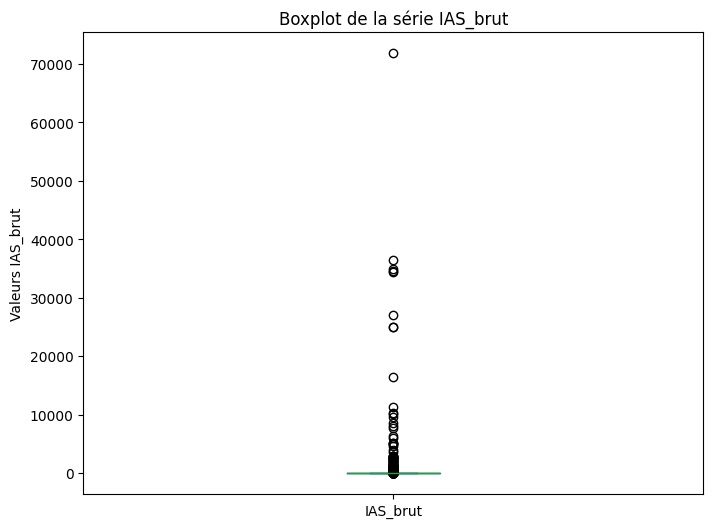

In [23]:
# Voir la distribution de la série temporelle pour établir la stratégie d'imputation
plt.figure(figsize=(8, 6))
df["IAS_brut"].plot(kind='box')
plt.title("Boxplot de la série IAS_brut")
plt.ylabel("Valeurs IAS_brut")
plt.show()

Il y a des valeurs très aberrantes dans la série temporelle. L'utilisation de la moyenne n'est pas une solution pour l'imputation. La médiane peut une solution mais les données sont écrasés par les valeurs aberrantes et on ne voit pas la plage de variation. Il faut faire une petite analyse pour pouvoir choisir la bonne méthode.

In [24]:
# Suppression des valeurs Nan et ajout des valeurs médianes
IAS_brut_mediane = df["IAS_brut"].median()
print(f"la valeur de la médiane est égale à : {IAS_brut_mediane}")
df["IAS_brut"] = df["IAS_brut"].replace(0, IAS_brut_mediane)
df["IAS_brut"] = df["IAS_brut"].fillna(IAS_brut_mediane)


la valeur de la médiane est égale à : 3.8


In [25]:
# Compter le nombre de zéros et de NaN dans la colonne 'IAS_brut'
nombre_NA = (df["IAS_brut"] == 0).sum() + df["IAS_brut"].isna().sum()
print(f"Nombre de zéros et de valeurs NaN (manquantes) dans 'IAS_brut': {nombre_NA}")

Nombre de zéros et de valeurs NaN (manquantes) dans 'IAS_brut': 0


# 2) Tracer la série temporelle

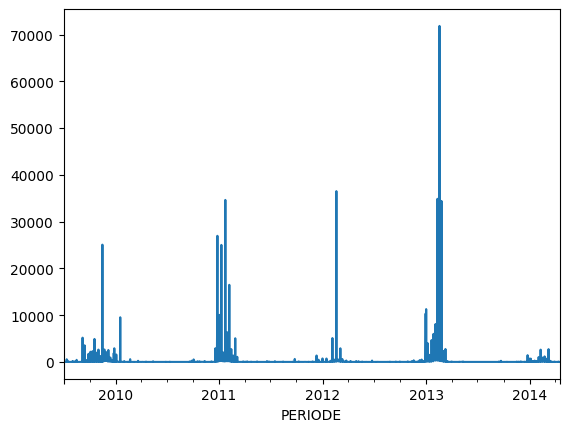

In [28]:
plt.figure()
df["IAS_brut"].plot()
plt.show()

L'indicateur synthétique épidémiologique est marqué par des périodes discontinues ou pas très visible entre les années. On voit aussi que les variances augmentent pour chaque année sauf en 2014 où on constate la baisse drastique des valeurs. 

# 3. Histogramme de la loi marginale

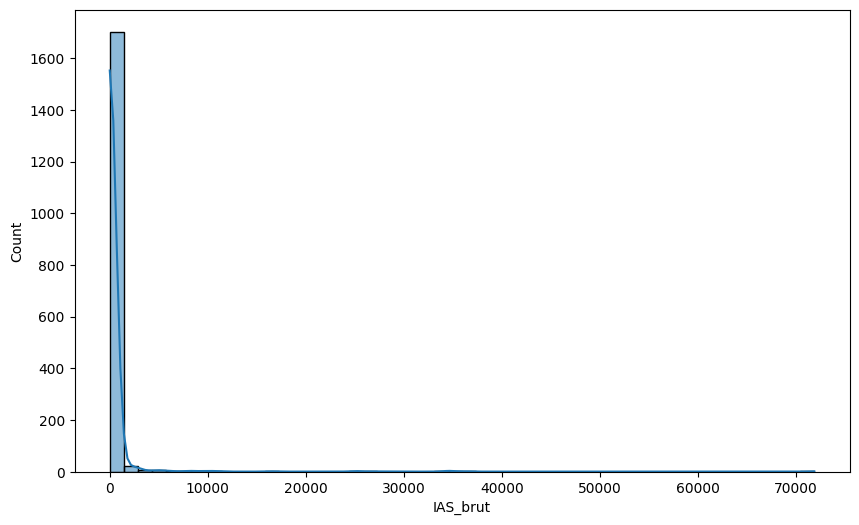

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(df['IAS_brut'], bins=50, kde=True)
plt.show()

La distribution est très concentrée sur 0. Par conséquent, il est difficile de voir l'évolution du graphique dans la question 2).  

# 4) Appliquer un logarithme sur les données et présenter graphiquement

In [31]:
df["IAS_brut_log"] = np.log(df["IAS_brut"])

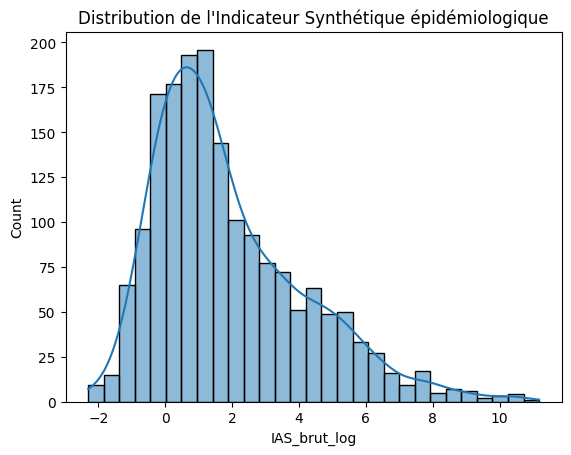

In [34]:
plt.figure()
sns.histplot(df["IAS_brut_log"], kde=True)
plt.title("Distribution de l'Indicateur Synthétique épidémiologique")
plt.show()

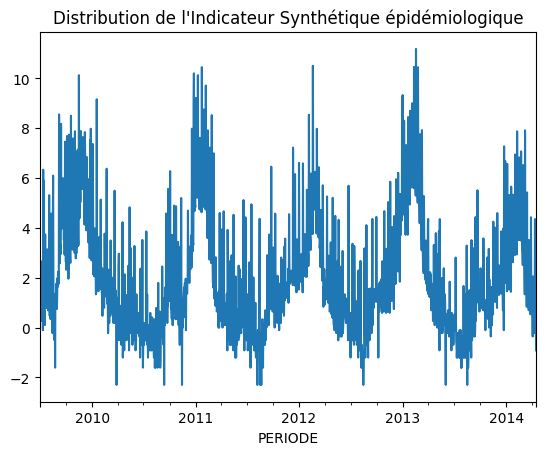

In [36]:
plt.figure()
df.IAS_brut_log.plot()
plt.title("Distribution de l'Indicateur Synthétique épidémiologique")
plt.show()

Le logarithme a modifié l'échelle des données à ce que les valeurs se rapprochent de 0. Ainsi, nous pouvons voir de très près l'évolution du Time series. 

Par constat, l'indicateur épidémiologique nous renseigne qu'il existe une saisonnalité annuelle. En effet, à chaque fin d'année, on observe une hausse des maladies afin d'atteindre un sommet à chaque début de la nouvelle année environ. 

# 5) Périodogramme des données

In [37]:
f, Pxx = periodogram(df["IAS_brut_log"], scaling = 'density')

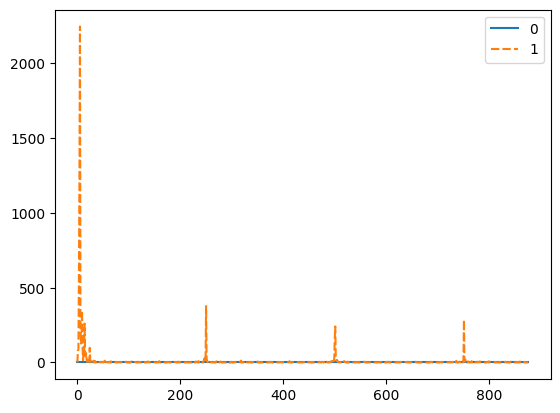

In [38]:
prd_gram = periodogram(df['IAS_brut_log'])
plot = sns.lineplot(prd_gram)

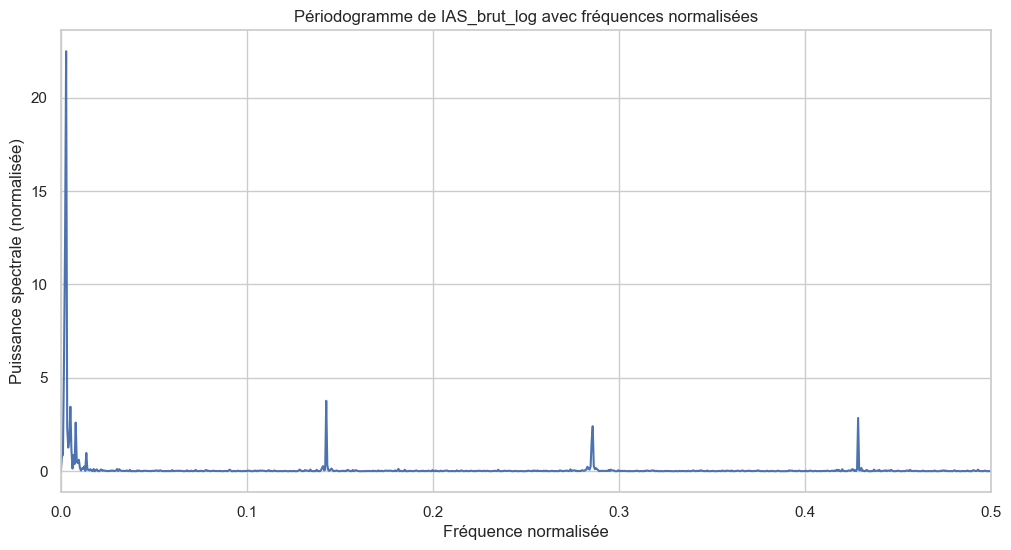

In [39]:
# Calculer le périodogramme
fs = 100
frequencies, powers = periodogram(df['IAS_brut_log'].values, fs=fs)

# Normaliser les fréquences pour l'affichage [-0.5, 0.5]
# Pour une série réelle, le spectre est symétrique, donc on peut doubler les puissances et utiliser seulement la moitié positive
normalized_frequencies = frequencies / fs

# Tracer le périodogramme
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x=normalized_frequencies, y=powers)
plt.xlim(0, 0.5)  # Afficher uniquement la partie positive du spectre
plt.title('Périodogramme de IAS_brut_log avec fréquences normalisées')
plt.xlabel('Fréquence normalisée')
plt.ylabel('Puissance spectrale (normalisée)')
plt.show()

Les pics représentent la présence de saisonnalité dans notre donnée et confirme notre observation précédente. 
Le pic le plus fort est proche de 0. Ce qui signifie que la saisonnalité se situe dans le zone de plus faible fréquence. Nécessairement, c'est l'année puisque c'est la fréquence la plus basse dans notre donnée. 

# 6) Supprimer une tendance périodique de période T

In [40]:
df_1 = df.copy()

In [41]:
s = df_1['IAS_brut_log']
idx = s.index

# Pour chaque t, chercher s[t - 1 an]
prev = s.reindex(idx - pd.DateOffset(years=1))
prev.index = idx  # réaligne sur l’index courant, plus de doublons

df_1['IAS_brut_log_filtre'] = s - prev


In [42]:
df_1['IAS_brut_log_filtre']

PERIODE
2009-07-01         NaN
2009-07-02         NaN
2009-07-03         NaN
2009-07-04         NaN
2009-07-05         NaN
                ...   
2014-04-13    3.256814
2014-04-14    0.117783
2014-04-15   -1.757858
2014-04-16   -0.446287
2014-04-17   -2.047693
Name: IAS_brut_log_filtre, Length: 1752, dtype: float64

In [43]:
# Supprimer les Nan : valeurs de l'année 2009
df_1 = df_1.dropna()
df_1.head()

,IAS_brut,IAS_brut_log,IAS_brut_log_filtre
PERIODE,,,
2010-07-01,1.0,0.000000,-0.530628
2010-07-02,0.9,-0.105361,-1.329136
2010-07-03,0.5,-0.693147,-1.435085
2010-07-04,1.2,0.182322,-0.080043
2010-07-05,0.6,-0.510826,-3.164068


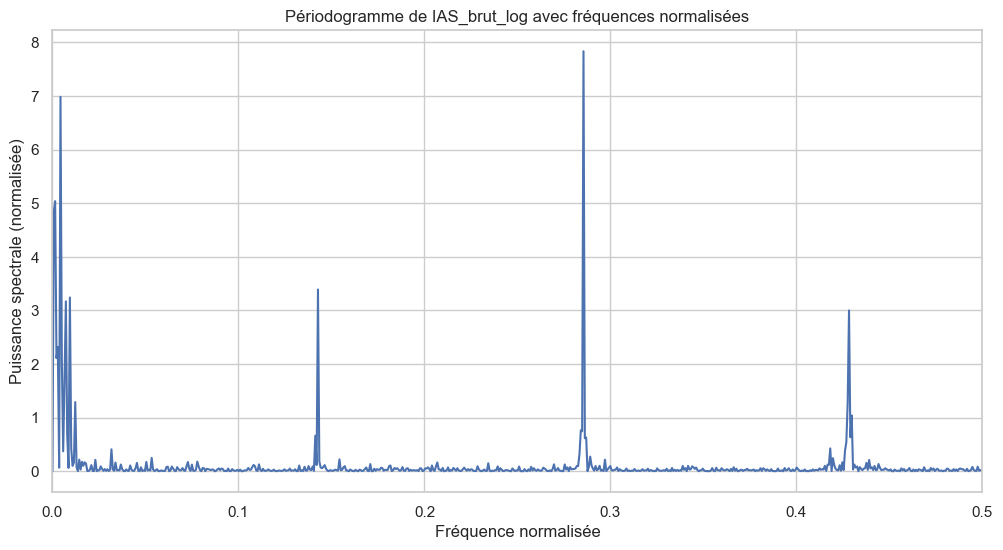

In [45]:
# Tracer le périodogramme
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x=normalized_frequencies, y=powers)
plt.xlim(0, 0.5)  # Afficher uniquement la partie positive du spectre
plt.title('Périodogramme de IAS_brut_log avec fréquences normalisées')
plt.xlabel('Fréquence normalisée')
plt.ylabel('Puissance spectrale (normalisée)')
plt.show()

Le premier pic est descendu de plus de 20 à inférieur à 8 en termes de puissance. Il est pratiquement disparu. 

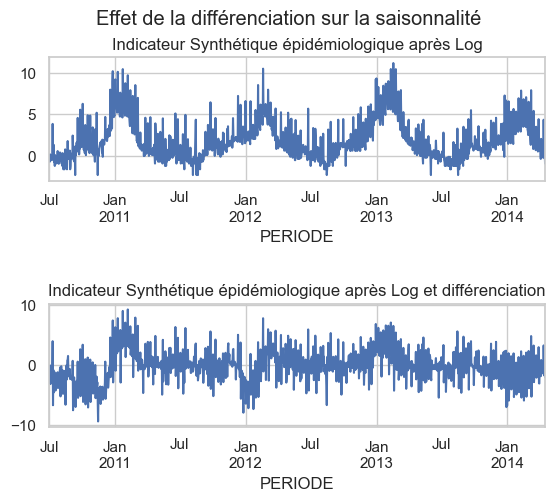

In [83]:
fig = plt.figure()
plt.suptitle("Effet de la différenciation sur la saisonnalité")

# Premier graphique
ax1 = fig.add_subplot(2,1,1)
df_1["IAS_brut_log"].plot(ax = ax1)
plt.title("Indicateur Synthétique épidémiologique après Log")

plt.subplots_adjust(hspace=1)

# Deuxième graphique
ax2 = fig.add_subplot(2,1,2)
df_1["IAS_brut_log_filtre"].plot(ax = ax2)
plt.title("Indicateur Synthétique épidémiologique après Log et différenciation")
plt.show()

# 7. Exercice de prévision à partir de la tendance

In [84]:
# --- Préparation des données ---
T = 365
n_harm = 3  # nombre d'harmoniques

In [85]:
# Extraire la période d'apprentissage
train = df_1.loc['2009-07-01' : '2013-03-31']
test = df_1.loc['2013-04-01' : '2014-04-17']

In [86]:
# Construire t (numéro du jour depuis le début)
t_train = np.arange(len(train))
t_test  = np.arange(len(train), len(train) + len(test))

In [87]:
# --- Fonction pour générer les variables harmoniques ---
def harmonic_features(t, T, n_harm):
    X = []
    for k in range(1, n_harm+1):
        X.append(np.cos(2 * np.pi * k * t / T))
        X.append(np.sin(2 * np.pi * k * t / T))
    return np.column_stack(X)

In [88]:
# Variables explicatives
X_train = harmonic_features(t_train, T, n_harm)
X_test  = harmonic_features(t_test,  T, n_harm)

In [89]:
train

,IAS_brut,IAS_brut_log,IAS_brut_log_filtre
PERIODE,,,
2010-07-01,1.0,0.000000,-0.530628
2010-07-02,0.9,-0.105361,-1.329136
2010-07-03,0.5,-0.693147,-1.435085
2010-07-04,1.2,0.182322,-0.080043
2010-07-05,0.6,-0.510826,-3.164068
...,...,...,...
2013-03-27,7.6,2.028148,1.195239
2013-03-28,7.1,1.960095,0.330854
2013-03-29,4.9,1.589235,0.280902


In [56]:
y_train = train['IAS_brut_log'].values

In [90]:
# --- Régression linéaire ---
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [91]:
# --- Prédiction ---
y_pred = model.predict(X_test)

# Ajouter les prédictions au DataFrame test
test = test.copy()
test['IAS_pred_log'] = y_pred

In [92]:
test.head()

,IAS_brut,IAS_brut_log,IAS_brut_log_filtre,IAS_pred_log
PERIODE,,,,
2013-04-01,78.1,4.357990,3.441699,1.703882
2013-04-02,3.8,1.335001,-0.596520,1.634980
2013-04-03,4.3,1.458615,0.205852,1.568180
2013-04-04,4.9,1.589235,0.426084,1.503537
2013-04-05,4.5,1.504077,-0.253781,1.441100


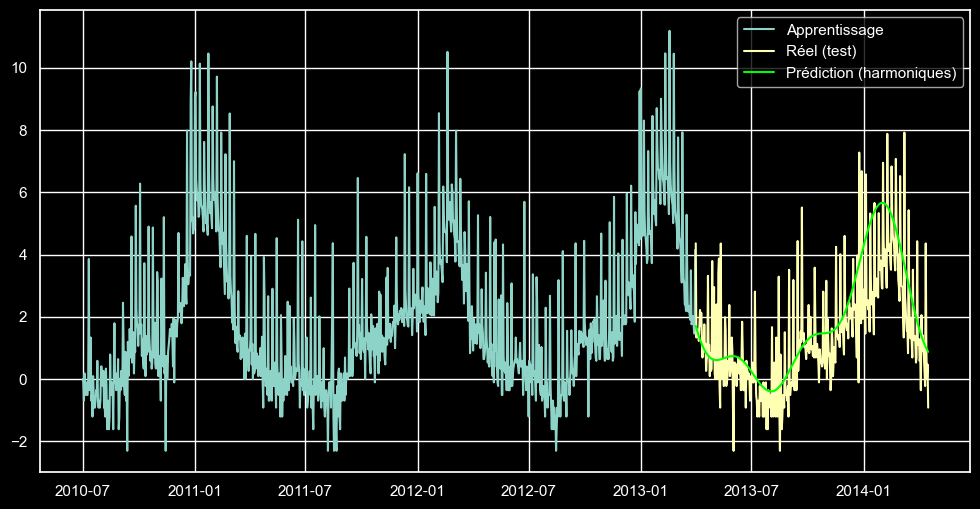

In [107]:
plt.figure(figsize=(12,6))
plt.style.use("dark_background")  # met le fond en noir
plt.plot(train.index, train['IAS_brut_log'], label="Apprentissage")
plt.plot(test.index, test['IAS_brut_log'], label="Réel (test)")
plt.plot(test.index, test['IAS_pred_log'], label="Prédiction (harmoniques)", color = "lime")
plt.legend()
plt.show()

In [108]:
# Risque pour la période
test = test.copy()
test["resid"] = test["IAS_brut_log"] - test["IAS_pred_log"]

In [109]:
# Risque quadratique (MSE)
mse = np.mean(np.square(test["resid"].dropna()))
print(f"Risque quadratique (MSE) sur la période 2013-04-01 → 2014-04-17 : {mse:.6f}")

Risque quadratique (MSE) sur la période 2013-04-01 → 2014-04-17 : 1.851125


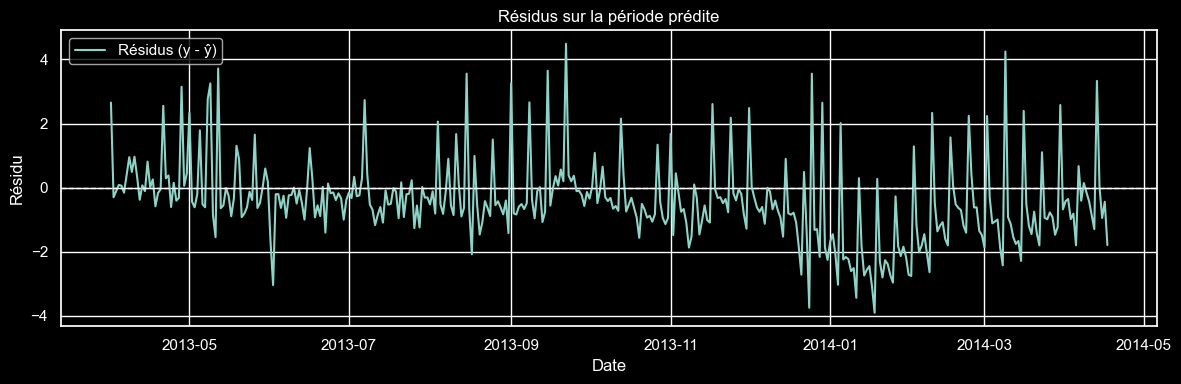

In [110]:
# 3) Tracés des résidus
# a) Résidus dans le temps
plt.figure(figsize=(12,4))
plt.plot(test.index, test["resid"], label="Résidus (y - ŷ)")
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Résidus sur la période prédite")
plt.xlabel("Date")
plt.ylabel("Résidu")
plt.legend()
plt.tight_layout()
plt.show()

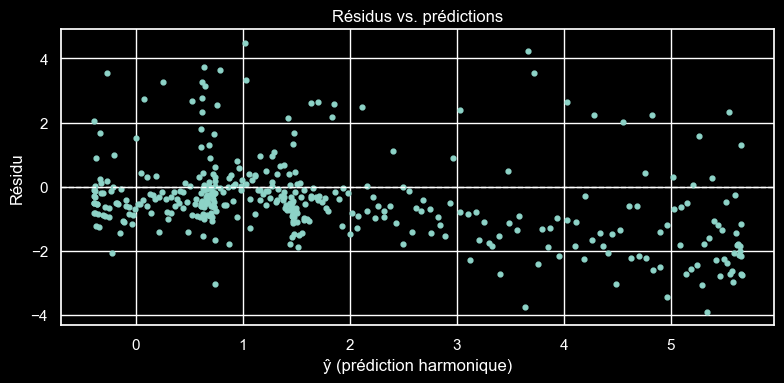

In [111]:
# c) vérifier l’homoscedasticité : voir si le résidu dépend de la taille de la prévision 
plt.figure(figsize=(8,4))
plt.scatter(test["IAS_pred_log"], test["resid"], s=12)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Résidus vs. prédictions")
plt.xlabel("ŷ (prédiction harmonique)")
plt.ylabel("Résidu")
plt.tight_layout()
plt.show()

Les résidus convergent vers 0 lorsque la prédiction est inférieure à 2. a partir de là, on voit un nouveau rythme. Il y a donc un hétéroscédasticité. 

Normalement, il faut continuer avec d'autres modèles puisque l'hypothèse d'homoscedasticité est violée. 